# Machine learning - sprint 2

Authors: Allart Ewoud, Van Hees Maxime, Breda Bram

## Introduction

The main focus of this paper is going to be about making prediction based on the images of the restaurant listings. We see alot of oppertunities where this can come in handy such as: 
- selecting the best pictures from a listing (the one where the model predicts the highest rating)
- ...

## Importing packages

To start off we're importing all the packages.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import glob
import PIL
import cv2

In [2]:
original_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")

# display the data and see how it formulated
pd.set_option("display.max_columns", None)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = original_df.select_dtypes(include=numerics)

## Case 1

For the first case we are going to look **if we can predict scores based on the images of the listings**. One of the first things where this can come to use is for choosing the best picture of an listing. Another thing that comes to mind is by determining if the pictures corresponds to the score. This can for example be used to tell the restaurants if they have bad or good pictures.

De predictie zal op basis van regressie zijn, en de predicte score kan een soort van metriek vormen die vertelt hoe goed de fotos van een restorant scoren tov van de andere restaurants.

**gevraagd aan de leerkracht en was een intressant idee, een goede combinatie is om dit eventueel te bekijken in combinatie met prijsklasse of price range**.

### preprocessing 

The first step is getting the scores and by adding the preprocessing steps.

In [3]:
# general rating
df = df.drop(columns=["atmosphere rating"])

df["general rating"] = original_df["general rating"].apply(lambda x: float(str(x).split(' ')[0]))
df["general rating"] = pd.to_numeric(df["general rating"])
mean = df["general rating"].loc[df["general rating"] != -1].mean()
df["general rating"] = df["general rating"].replace(-1,mean)

df.head()

,food rating,service rating,value rating,id,general rating
0,5.0,5.0,4.5,13969825,5.0
1,5.0,5.0,4.5,740727,5.0
2,4.5,4.5,4.5,12188645,4.5
3,5.0,4.5,5.0,9710340,5.0
4,4.5,4.5,4.5,8298124,4.5


In [4]:
# Getting list of all images
fileNameList = glob.glob("tripadvisor_dataset/tripadvisor_images/*.jpg")
images = []

# putting all images in a dict where the key is the name of the picture
for fileName in tqdm(fileNameList, total=len(fileNameList)):
    try:
        img = Image.open(f"{fileName}")
        img = img.resize((128,128))
        img_np = np.array(img).flatten()
        #TODO resize all the images
        images.append(pd.Series(data=[fileName.split('/')[-1].split("_")[0], img_np]))
        
    except PIL.UnidentifiedImageError:
        pass

# changing the list of pd.Series to pandas dataframe
images = pd.concat(images, axis=1).T
images = images.rename(columns={0 : "id", 1 : "pixels"})
images["id"] = pd.to_numeric(images["id"])

# merging 2 dataframes
df = pd.merge(df, images, on="id")

df.head()

100%|████████████████████████████████████| 15183/15183 [00:59<00:00, 257.09it/s]


,food rating,service rating,value rating,id,general rating,pixels
0,5.0,5.0,4.5,13969825,5.0,"[135, 93, 45, 125, 84, 42, 158, 118, 67, 176, ..."
1,5.0,5.0,4.5,13969825,5.0,"[96, 67, 37, 90, 63, 33, 74, 48, 21, 78, 53, 2..."
2,5.0,5.0,4.5,13969825,5.0,"[37, 34, 28, 42, 36, 22, 65, 50, 18, 85, 63, 9..."
3,5.0,5.0,4.5,13969825,5.0,"[234, 223, 203, 169, 158, 138, 168, 157, 137, ..."
4,5.0,5.0,4.5,13969825,5.0,"[56, 46, 36, 54, 44, 34, 52, 42, 32, 52, 42, 3..."


In [5]:
df["pixel_size"] = df["pixels"].apply(lambda x: len(x))
df = df.drop(df[df.pixel_size != 49152].index)
df.head()

,food rating,service rating,value rating,id,general rating,pixels,pixel_size
0,5.0,5.0,4.5,13969825,5.0,"[135, 93, 45, 125, 84, 42, 158, 118, 67, 176, ...",49152
1,5.0,5.0,4.5,13969825,5.0,"[96, 67, 37, 90, 63, 33, 74, 48, 21, 78, 53, 2...",49152
2,5.0,5.0,4.5,13969825,5.0,"[37, 34, 28, 42, 36, 22, 65, 50, 18, 85, 63, 9...",49152
3,5.0,5.0,4.5,13969825,5.0,"[234, 223, 203, 169, 158, 138, 168, 157, 137, ...",49152
4,5.0,5.0,4.5,13969825,5.0,"[56, 46, 36, 54, 44, 34, 52, 42, 32, 52, 42, 3...",49152


In [6]:
from skimage.feature import hog
from skimage import exposure

def hog_transformer(img):
    if len(img) != 49152:
        print("check")
        print(img.shape)
        return np.empty(0)
    
    img = img.reshape(128,128,3)
    
    fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return np.array(fd).flatten()

df['hog'] = df['pixels'].apply(hog_transformer)

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time

images = np.stack(df['pixels'].values)
images_hogs = np.stack(df['hog'].values)

scaler_pixels = StandardScaler()
pixels_scaled = scaler_pixels.fit_transform(images)

scaler_hog = StandardScaler()
hogs_scaled = scaler_hog.fit_transform(images_hogs)

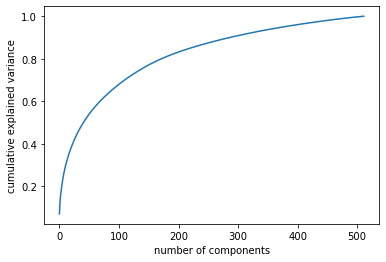

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
data_reduced = pca.fit_transform(hogs_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Ik vermoed nu dat we die hogs in ons dataframe moeten steken